<a href="https://colab.research.google.com/github/Andrey-Mel/segmentarion_img/blob/main/Segmentation_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Подключение библиотек
from tensorflow.keras.models import Model # модель из керас - Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization,Conv2DTranspose, concatenate, Activation, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K #Импортируем модкль backend от Keras
from tensorflow.keras.optimizers import Adam #импортируем оптимизатор
from tensorflow.keras import utils #импорт модуля utils библиотеки tensorflow.keras для получения OHE
from google.colab import files #импорт модуля files для работы с файлами в колаб
import matplotlib.pyplot as plt #импортируем модуль pyplot библиотеки matplotlib для работы с графиками
from tensorflow.keras.preprocessing import image #импортируем модуль image для работы с изображениями
import numpy as np #импорт библиотки numpy
from sklearn.model_selection import train_test_split
import time
import random
import os #импортируем библиотеку для работы с файловой системой
from PIL import Image #импортируем модуль Image для работы с изображениями
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




Сделайте выделение классов по отдельности:
*   Пола
*   Того, что за окном
*   Людей
*   Батарей
*   Лампочек
*   Все остальное - фон
 
Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке



In [ ]:
#СЕГМЕНТАЦИЯ СТРОЙКИ

#Загрузка изображений

#Глобальные параметры
img_weight = 176
img_height = 240
num_classes = 6 #Задаем количество классов на сегментирование изображений
directory = '/content/drive/My Drive/Сегментация/' #указываем путь к обучающей выборки
train_directory = 'Тренировочная_стройка'#Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка'#Название папки с файлами проверочной выборки

In [ ]:
#Оригинальные изображения из папок заносим в list

train_images = []#создаем список для хранения оригинальных изображений обучающей выборки
val_images = []#список изображений для хранения оригинальных изображений проверочной выборки

cur_time = time.time() #засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory + '/Исходники')):# Проходим по всем файлам в каталоге по указанному пути 
  train_images.append(image.load_img(os.path.join(directory + train_directory + '/Исходники',filename),
                                     target_size=(img_weight, img_height)))# Читаем очередную картинку и добавляем ее в список изображения с указанным размером target_size 
print('Обучающая выборка загружена. Время загрузки: ',round(time.time() - cur_time,2),'c',sep='')#время загрузки картинок обучающей выборки
print('Количество изображений: ',len(train_images))

cur_time = time.time()#текущее время
for filename in sorted(os.listdir(directory + val_directory + '/Исходники')):
  val_images.append(image.load_img(os.path.join(directory + val_directory + '/Исходники',filename),
                                   target_size=(img_weight, img_height)))
print('Проверочная выборка загружена.Время загрузки: ',round(time.time() - cur_time,2),'c',sep='')
print('Количество изображений в проверочной выборке',len(val_images))

Обучающая выборка загружена. Время загрузки: 363.81c
Количество изображений:  900
Проверочная выборка загружена.Время загрузки: 20.55c
Количество изображений в проверочной выборке 50


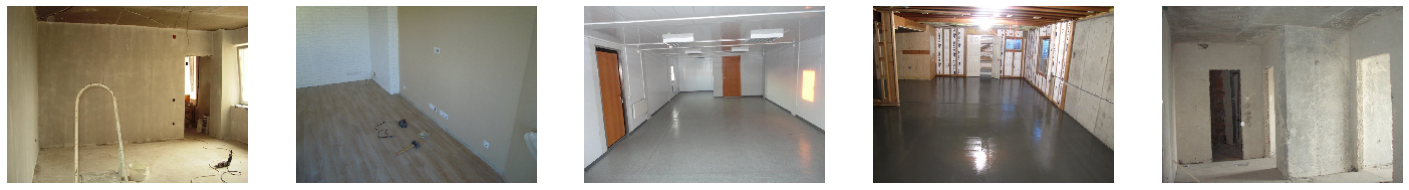

In [ ]:
n=5 #количество случчайных картинок
fig, axs = plt.subplots(1,n, figsize=(25,10))#создаем полотно из n графиков
for i in range(n):
  img = random.choice(train_images)#выбираем случайные фото
  axs[i].axis('off')
  axs[i].imshow(img)
plt.show()

In [ ]:
#сегментированные изображения

train_segments = []
val_segments =[]

cur_time = time.time()
for filename in sorted(os.listdir(directory + train_directory + '/Размеченные')):
  train_segments.append(image.load_img(os.path.join(directory + train_directory + '/Размеченные',filename),
                                      target_size=(img_weight, img_height)))
print('Обучающая выборка сегментированных изображений загружена.Время загрузки: ', round(time.time()-cur_time,2), 'c', sep='')
print('Количество сегментированных изображений', len(train_segments))

cur_time = time.time()
for filename in sorted(os.listdir(directory + val_directory + '/Размеченные')):
  val_segments.append(image.load_img(os.path.join(directory + val_directory + '/Размеченные',filename),
                                    target_size=(img_weight, img_height)))
print('Тестовая выборка сегментированных изображений загруженна. Время загрузки: ', round(time.time() - cur_time,2))
print('Количество сегментированных изображений', len(val_segments))

Обучающая выборка сегментированных изображений загружена.Время загрузки: 401.42c
Количество сегментированных изображений 900
Тестовая выборка сегментированных изображений загруженна. Время загрузки:  21.06
Количество сегментированных изображений 50


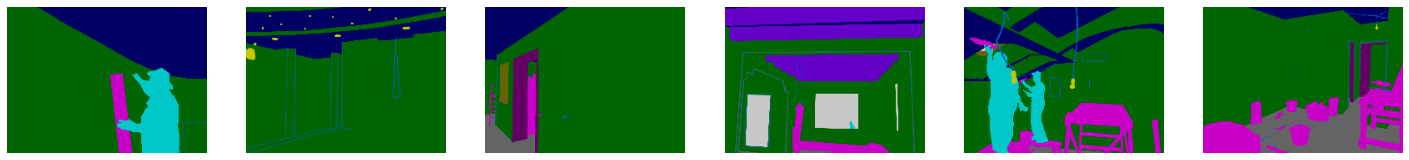

In [ ]:
n = 6
fig, axs = plt.subplots(1,n,figsize=(25,10))
for i in range(n):
  img = random.choice(train_segments)
  axs[i].axis('off')
  axs[i].imshow(img)
plt.show()

In [ ]:
#СОЗДАНИЕ ВЫБОРКИ

#Функция преобразования пикселя сегментированного изображения в индекс (6 классов)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # пол                 ПОЛ
  #elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1 # потолок
  #elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=2 # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=3#4 # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=1#3 # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1#3 # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=1#3 # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=4 # внешний мир.  ТО ЧТО ЗА ОКНОМ
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151) : index=2#4 # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=2#4 # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=2#4 # батарея              БАТАРЕЙ
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=4#5 # люди             ЛЮДЕЙ
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=2#4 # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=2#4 # источники света     ЛАМПОЧЕК
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151) : index=2#4 # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=2#4 # балка
  else: index=5#6#                                                                                     ВСЕ ОСТАЛЬНОЕ ФОН
  return index  

In [ ]:
#Функция преобразования индекса в цвет???
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0: color = [100,100,100] #пол
  elif index == 1: color = [0,0,100]#проем дверь окно
  elif index == 2: color = [0,100,0]#источники света
  elif index == 3: color = [100, 0, 0]#проем дверь окно
  elif index == 4: color = [0,100,100]#колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100,0,100]#люди
  #elif index == 6: color = [0,0,0]#остальное
  return color

In [ ]:
#Функция перевода индекса пикселя в to_categorical
def rgbToone(y, num_classes):
  y2 = y.copy()
  y = y.reshape(y.shape[0] * y.shape[1],3)
  yt = []#создаем пустой лист
  for i in range(len(y)): #проходим по всем трем каналам изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) #переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) #преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes)#решейпим к исходному размеру
  return yt

In [ ]:
#Функция формирования y_train
def yt_prep(data, num_classes):
  yTrain = []
  for seg in data: #Пробегаем по всем файлам набора с сегментированными изображениями
    y = image.img_to_array(seg) #переводим в numpy массив высота - ширина - количество каналов
    y = rgbToone(y, num_classes)#получаем ohe - представление сформированного массива
    yTrain.append(y) #добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: #Каждые 100 шагов
      print(len(yTrain))#выводим количество обработанных изображений
  return np.array(yTrain) #возвращаем сформированный yTrain

In [ ]:
#Формируем xTrain
xTrain = [] #пустой список под обучающую выборку
for img in train_images: #проходим по всем изображениям в списке train_images
  x = image.img_to_array(img) #переводим изображение в numpy массив
  xTrain.append(x)
xTrain = np.array(xTrain) #переводим в numpy

In [ ]:
print(xTrain.shape)

(900, 176, 240, 3)


In [ ]:
#формируем валидационную выборку
xVal = []
for img in val_images:
  x = image.img_to_array(img) #переводим изображение в numpy-массив размерностью высота - ширина - количество каналов
  xVal.append(x)
xVal = np.array(xVal)

In [ ]:
print(xVal.shape)

(50, 176, 240, 3)


In [ ]:
cur_time = time.time()
yTrain = yt_prep(train_segments, num_classes)
print('Время обработки: ',round(time.time()-cur_time,2),'c')

100
200
300
400
500
600
700
800
900
Время обработки:  2911.88 c


In [ ]:
cur_time = time.time()
yVal = yt_prep(val_segments, num_classes)
print('Время обработки: ',round(time.time()-cur_time,2),'c')

Время обработки:  129.75 c


In [ ]:
yTrain.shape

(900, 176, 240, 6)

In [ ]:
#ФУНКЦИЯ ВИЗУАЛИЗАЦИИ СЕГМЕНТИРОВАННЫХ ИЗОБРАЖЕНИЙ

def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal),count)# получаем count случайных индексов
  fig,axs = plt.subplots(3, count, figsize=(25,15))#Создаем полотно  из n графиков
  for i, idx in enumerate(indexes): #проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1,img_weight,img_height,3)))#предиктим картинку
    pr = predict[0] #берем нулевой элемент предикта
    pr1 = []#пустой лист под сегментированную картинку из предикта
    pr2 = [] #пустой под сегментированную картинку из xVal
    pr = pr.reshape(-1, n_classes) #решейп предикта
    #print(pr.shape)
    yr = yVal[idx].reshape(-1, n_classes) #решейп yVal
    #print(yr.shape)
    for k in range(len(pr)): #Проходим по всем уровням (количество классов)
      pr1.append(index2color(pr[k])) #переводим индекс в пиксель
      pr2.append(index2color(yr[k])) #переводим индекс впиксель
      
    pr1 = np.array(pr1) #преобразуем в numpy
    #print(pr1.shape)
    pr1 = pr1.reshape(img_weight, img_height, 3) #решейпим к размеру изображения
    pr2 = np.array(pr2)#преобразование в numpy
    pr2 = pr2.reshape(img_weight, img_height, 3)#решейп к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) #получаем картинку из предикта
    axs[0,i].imshow(img.convert('RGBA'))#????? Отображаем на графике в первой линии сегментированное изображение из предикта
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8')))## Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8')))
    axs[2,i].axis('off')
  plt.show()

In [ ]:
#Собственная функция метрикиб обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true *y_pred) + 1.)/(K.sum(y_true)+K.sum(y_pred) + 1.)#возвращаем площадь пересечения на площадь объединения

In [ ]:
#МОДЕЛЬ

#функция создание сети
'''
  Функция создания сети
    Входные параметры:
      - num_classes - количество классов
      - input_shape - размерность карты сегментации
'''
# def linearSegmentationNet(num_classes = 7, input_shape=(176,240,3)):
#   img_input = Input(input_shape)#входной слой с размерностью input_shape (176,240,3)
#   x = Conv2D(128,(3,3),padding='same', name='block1_conv1')(img_input)# Conv2D-слой с 128-нейронами(176,240,128)
#   x = BatchNormalization()(x)#слой нормализации 176,240,128
#   x = Activation('relu')(x)#активационная функция (176,240,128)

#   x = Conv2D(128,(3,3),padding='same',name='block1_conv2')(x)#(176,240,128)
#   x = BatchNormalization()(x)
#   x = Activation('relu')(x)

#   x = Conv2D(num_classes, (3,3), activation='softmax',padding='same')(x)#176,240,6

#   model = Model(img_input, x)

#   #Компилируем модель
#   model.compile(optimizer = Adam(lr = 0.001),
#                 loss='categorical_crossentropy',
#                 metrics = [dice_coef])
#   return model

def unet_my(num_classes = 3, input_shape=(88,120,3)):
  img_input = Input(input_shape)

  #Block 1
  x = Conv2D(64,(3,3), padding='same', name='block1_conv1')(img_input)
  x = Activation('relu')(x)

  x = Conv2D(64, (3,3), padding='same', name='block1_conv2')(x)
  block_1_out = Activation('linear')(x)

  x = MaxPooling2D() (block_1_out) #выходной макспулинг

  #Block2
  x = Conv2D(128,(3,3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)

  x = Conv2D(128, (3,3), padding='same', name='block2_conv2')(x)
  block_2_out = Activation('relu')(x)

  x = MaxPooling2D()(block_2_out)

  #Block 3
  x = Conv2D(256,(3,3),padding='same', name='block3_conv1')(x)
  x = Conv2D(256, (3,3), padding='same', name='block3_conv2')(x)
  x = Activation('relu')(x)
  block_3_out = Activation('relu')(x)

  x = MaxPooling2D()(block_3_out)

  #UP1
  x = Conv2DTranspose(256,(2,2), strides=(2,2), padding='same')(x)
  x = Activation('tanh')(x)
  x = concatenate([x, block_3_out])
  x = Conv2D(256,(3,3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(256,(3,3),padding='same')(x)
  x = Activation('tanh')(x)


  #UP2
  x = Conv2DTranspose(128, (2,2),strides=(2,2), padding='same')(x)
  x = Activation('relu')(x)
  concatenate([x, block_2_out])
  x = Conv2D(128, (3,3), padding='same')(x)
  x = Conv2D(128, (3,3), padding='same')(x)
  x = Activation('linear')(x)

  #UP3
  x = Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)

  x = concatenate([x, block_1_out])
  x = Conv2D(64,(3,3), padding='same')(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('tanh')(x)
  x = Conv2D(64,(3,3), padding='same')(x)
  x = Conv2D(num_classes, (3,3), activation='sigmoid',padding='same')(x)

  model = Model(img_input, x)

  model.compile(optimizer=Adam(lr=0.0001),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model



In [ ]:
# modelL = linearSegmentationNet(num_classes,(img_weight,img_height,3))
# modelL.summary()
model_U = unet_my(num_classes,(img_weight,img_height,3))
model_U.summary

<bound method Model.summary of <tensorflow.python.keras.engine.functional.Functional object at 0x7f1050d727b8>>

In [ ]:
model_U.compile(optimizer=Adam(lr=0.00001),
                loss='categorical_crossentropy',
                metrics=[dice_coef])

Epoch 1/40
57/57 [==============================] - 28s 484ms/step - loss: 1.3079 - dice_coef: 0.3433 - val_loss: 1.9543 - val_dice_coef: 0.2459
Epoch 2/40
57/57 [==============================] - 26s 461ms/step - loss: 0.9975 - dice_coef: 0.3429 - val_loss: 1.6263 - val_dice_coef: 0.2725
Epoch 3/40
57/57 [==============================] - 26s 451ms/step - loss: 0.9193 - dice_coef: 0.3758 - val_loss: 1.3317 - val_dice_coef: 0.3193
Epoch 4/40
57/57 [==============================] - 26s 462ms/step - loss: 0.9093 - dice_coef: 0.3671 - val_loss: 1.2132 - val_dice_coef: 0.3349
Epoch 5/40
57/57 [==============================] - 26s 460ms/step - loss: 0.8530 - dice_coef: 0.4052 - val_loss: 1.2941 - val_dice_coef: 0.3102
Epoch 6/40
57/57 [==============================] - 26s 457ms/step - loss: 0.8320 - dice_coef: 0.4147 - val_loss: 1.2274 - val_dice_coef: 0.3039
Epoch 7/40
57/57 [==============================] - 26s 458ms/step - loss: 0.8043 - dice_coef: 0.4418 - val_loss: 1.1467 - val_dic

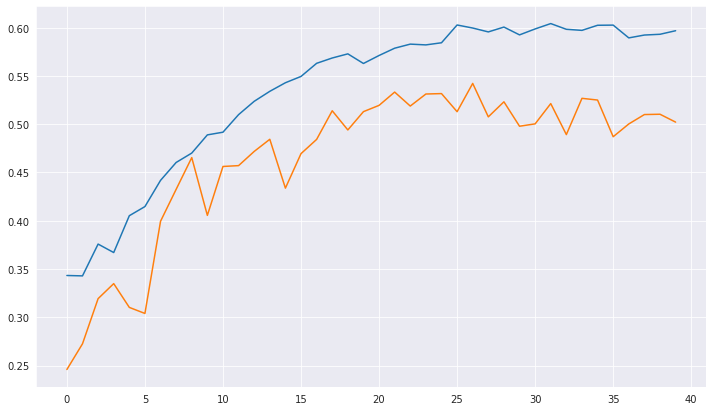

In [ ]:
#history = modelL.fit(xTrain,yTrain,epochs=10,batch_size=32,validation_data=(xVal,yVal))
history = model_U.fit(xTrain,yTrain,epochs=40,batch_size=16,validation_data=(xVal,yVal))

#Отобразим графики
plt.figure(figsize=(12,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
model_U.save_weights('/content/drive/My Drive/урок весы 25/model_U.h5')

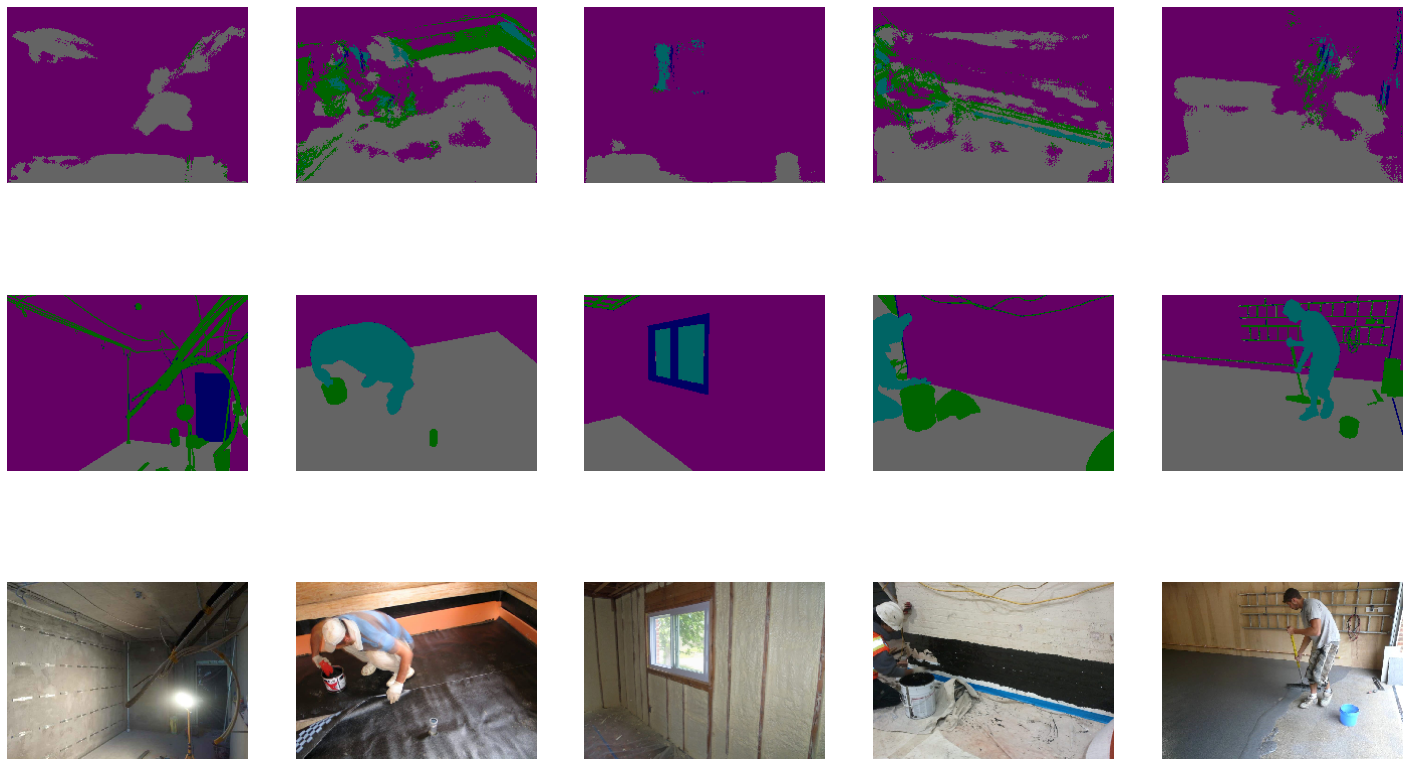

In [ ]:
#Распознавание
processImage(model_U,5,num_classes)

**Выводы по занятию**

По результатам экпериментов по изменению разного размера batch_size, можно сказать что больше размер батча или меньше, он на качество обучения не так влияет как активационные функции. Например при batch_size = 32 валидационная точность val_dice_coef = 59%, при батче = 64 - точность равна = 64%, при батче=16 val_dice_coef = 68%. Эти наблюдения проводились при epochs=10. А вот если, в этой сети, меняю вместо активационной функции RELU менял и пробовал разные другие функции,такие как SIGMOID, TANH,LINEAR, в разных вариантах, у меня лучшая точность достигла всего лишь 53% на проверочной выборке. Одним словом, активационные функции имеют больше влияния результат чем батч сайз. Но по результату своих изображений изменненых как сказано в задании в цветах(то есть не отображать стены, потолок и тд), особо сказть ничего не могу, так как может я не правильно распределил цвета для отбражения в сегментых изображениях.  



Напишите PSPNet для сегментации на базе стройки, добейтесь максимально возможной точности.

Может получится добиться результатов лучше чем по предыдущему заданию.

Так как подготовлены все данные по выборкам, начну сразу с создания PSPnet.


In [ ]:
'''
  Функция создания сети
    Входные параметры:
      - num_classes - количество классов
      - input_shape - размерность карты сегментации
'''
def my_PSPNet(num_classes = 3, input_shape = (176,240,3)):
  img_input = Input(input_shape)
  #Блок сверточных слоев Conv2D
  x = Conv2D(32, (3,3), padding = 'same')(img_input)
  x = Conv2D(32, (3,3), padding = 'same')(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = Conv2D(64,(3,3),padding='same')(x)
  x = Activation('relu')(x)
  
  
  #Блок Макспулинга и Апсемплинга, то есть сжимаем и разжимаем
  x = Activation('relu')(x)
  MaxPool1 = MaxPooling2D((16,16))(x) #не сжимаю на 32 так как размер 176 на 32 делится с остатком
  OutMaxPool1 = UpSampling2D((16,16))(MaxPool1)

  x = Activation('relu')(x)
  MaxPool2 = MaxPooling2D((8,8))(x)
  OutMaxPool2 = UpSampling2D((8,8))(MaxPool2)

  x = Activation('relu')(x)
  MaxPool3 = MaxPooling2D((4,4))(x)
  OutMaxPool3 = UpSampling2D((4,4))(MaxPool3)
  
  x = Activation('relu')(x)
  MaxPool4 = MaxPooling2D((2,2))(x)
  OutMaxPool4 = UpSampling2D((2,2))(MaxPool4)

  #Конкатенация
  x = concatenate([x,OutMaxPool1, OutMaxPool2, OutMaxPool3, OutMaxPool4]) #объединяю все сжатые и разжатые слои
  


  #Выходной блок сверточных слоев Conv2D
  x = Conv2D(128,(3,3),padding='same')(x)
  x = Conv2D(128,(3,3),padding='same')(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3),padding='same')(x)
  x = Conv2D(64,(3,3), padding='same')(x)
  x = Activation('relu')(x)

  #Выходной слой
  x = Conv2D(num_classes, (3,3), activation='softmax', padding='same')(x)

  #собираем модель (с начальными и конечными данными)
  model = Model(img_input, x) #начальные данные это размер изображения, x - конечные полученные данные из выходного слоя

  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=[dice_coef])
  
  return model


In [ ]:
#Создаю модель PSPNet (как я думаю)
model_psp_my = my_PSPNet(num_classes,(img_weight,img_height,3))

In [ ]:
model_psp_my.compile(optimizer=Adam(lr = 0.00001),
                loss='categorical_crossentropy',
                metrics=[dice_coef])

In [ ]:
model_psp_my.summary()

Model: "functional_37"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_222 (Conv2D)             (None, 176, 240, 32) 896         input_30[0][0]                   
__________________________________________________________________________________________________
conv2d_223 (Conv2D)             (None, 176, 240, 32) 9248        conv2d_222[0][0]                 
__________________________________________________________________________________________________
activation_89 (Activation)      (None, 176, 240, 32) 0           conv2d_223[0][0]                 
______________________________________________________________________________________

Epoch 1/5
29/29 [==============================] - 36s 1s/step - loss: 0.7300 - dice_coef: 0.6267 - val_loss: 1.0507 - val_dice_coef: 0.5243
Epoch 2/5
29/29 [==============================] - 36s 1s/step - loss: 0.7279 - dice_coef: 0.6295 - val_loss: 1.0451 - val_dice_coef: 0.5267
Epoch 3/5
29/29 [==============================] - 37s 1s/step - loss: 0.7256 - dice_coef: 0.6311 - val_loss: 1.0512 - val_dice_coef: 0.5271
Epoch 4/5
29/29 [==============================] - 37s 1s/step - loss: 0.7267 - dice_coef: 0.6321 - val_loss: 1.0487 - val_dice_coef: 0.5279
Epoch 5/5
29/29 [==============================] - 37s 1s/step - loss: 0.7251 - dice_coef: 0.6319 - val_loss: 1.0560 - val_dice_coef: 0.5272


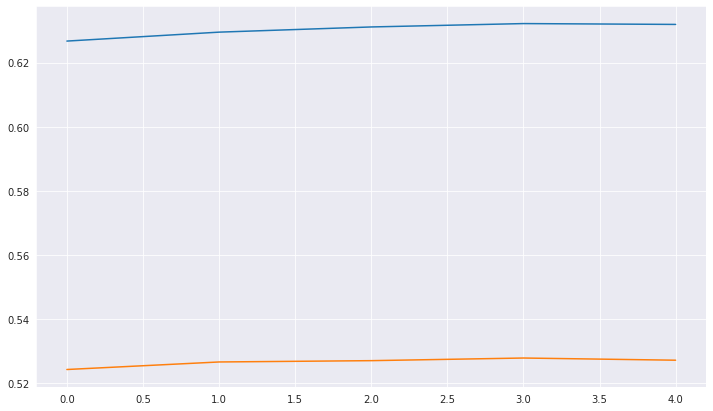

In [ ]:
#Обучение сети
historyP = model_psp_my.fit(xTrain, yTrain, epochs=5, batch_size=32, 
                           validation_data=(xVal, yVal))
plt.figure(figsize=(12,7))
plt.plot(historyP.history['dice_coef'])
plt.plot(historyP.history['val_dice_coef'])
plt.show()

In [ ]:
#model_psp_my.save_weights('/content/drive/My Drive/урок весы 25/model_psp_my')
model_psp_my.load_weights('/content/drive/My Drive/урок весы 25/model_psp_my')

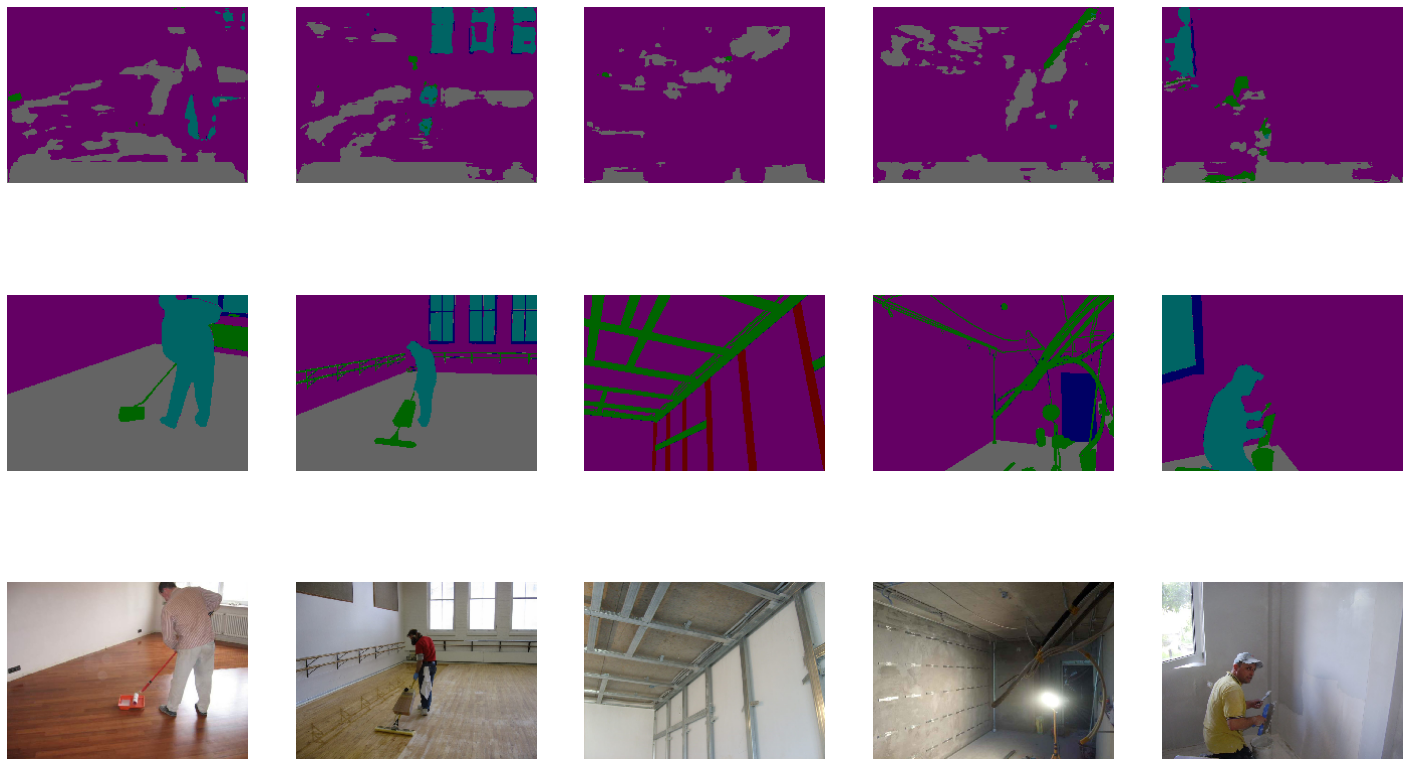

In [ ]:
#Распознавание
processImage(model_psp_my,5,num_classes)

Вот у меня получился самый лучший результат, со всеми активационными функциями RELU. Вот только так добился хоть какого-то немного совместимого изображения с сегментным проверочным изображением. Да и по цифровой точности у меня с такой архитектурой сети получилась тояность до 53%